# Kian's yt Cookbook
### Kian Hayes

This notebook serves the purpose of documenting some of the techniques and Python scripts I used to create certain YT 3D renders. I'll first go through how YT makes a 3D render to set up some background and logic for certain commands that will be used in the scripts. I'll then move on to showing specific scripts, going in depth in what's happening inside of the code along with some of the results from those scripts.

## What is 3D Rendering in YT?

3D Rendering in YT is entirely object oriented. Every piece of a render is contained within a YT class object. These objects include the data itself, the volume that data is contained in, the Scene that hosts all objects, the Transfer Function, and the camera including its' lense. All of these objects must be initialized and certain commands called wihtin those objects in order for you to produce good renders. There's a nice graphic on the YT Project website demonstrating all these objects physically that I'll link in here. To put simply, all these objects interact with each other and effect the ray tracing that goes on under the hood of YT in order to produce a 3D render. 

<PHOTO>

We'll now go into what all these objects are, what they do, and how they're called in a Python script.

## Class Objects within YT's 3D Rendering and Guided Example

This section serves the purpose of explaining all the objects associate with 3D rendering and along the way mentioning some helpful tips that I've learned that make coding more efficient or certain commands that I've found create good renders. I'll go in depth on these concepts, spending time to really explain what's going on line by line so if you just want a quick example showing a full script I've made that will produce a 3D render then skip this part.

### The Data

The data isn't necessarily an object, but it's important to call it and load it inside of your script so YT knows what data you're working with. This is done simply with the following:

In [ ]:
import yt
import unyt
from yt.visualization.volume_rendering.api import Scene, create_volume_source
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
import numpy as np

ds = yt.load('file.h5')

First, it's required that we have the many import statements at the top there since yt does not load the specific things associated with 3D Renders with just `import yt`. We'll use numpy for many things associated with converting numbers to log space later. 

The data is typically in the format HDF5. The data that we work with is mostly HDF5 so I'm not sure if YT is capable of loading other types of data. You likely won't have to worry about that with data from the Maestro and FLASH code as they output their plt files as HDF5. The argument passed into `load` can also be a path which is often how I do it since it's likely that my python script's working directory will not be where my data is stored. Within this, you can use the wildcard character to load all data in a directory following a defined pattern as in `yt.load('some/directory/with/data/plt_cnt_*')` which is useful when making time series movies.

### The Data Volume Object

There are several different volume objects that you can pass your loaded data into but the main one that I've used is the 'Sphere' object. It is initialized by doing the following

In [ ]:
ds = yt.load('file.h5')
radius = (2e3, 'km')
core = ds.sphere(ds.domain_center, radius)

This is a simple block of code but there are a lot of YT specific things going on the arguments that I would like to explain. First is defining the radius which is specifically associated with the radius of our Data Volume Object. I've made this a tuple where the zero element is the magnitude I want the radius to be and the first element the units I want that magnitude to be. This is a good variable to define at the beginning because there will be many situations where we only need the magnitude of the radius in future commands in which we can just write `radius[0]`. In other cases where we need both we just pass in the whole variable. 

Now for the `core` assignment which creates our Data Volume Object. The general call to assign our data to a volume is `ds.<volume_type>(center, radius_of_volume)` where `volume_type` can be any volume avaible within YT. It's important to note that the `center` argument must be a 3 dimensional cartesian coordinate within our data in the form of a list as in `[x, y, z]`, although we can use `ds.domain_center` which will return the center of our data without us having to do much work. 

### Field Volume Source

Now that we have all our data inside of a volume, we need to create a seperate volume source for the specific field. This is done with the following:

In [ ]:
field = ('boxlib', 'X(na23)')
my_source = create_volume_source(ds, field)

Another useful tip I'd like to explain is done here. **Define the specific field you want to render at the beginning of your script**. There are A LOT of commands in YT that require you to pass in the field you're working with. It can be a pain to type the tuple with the two strings every time we need to do this so make your life easier and put it in a variable. 

With that out of the way, we then create our Field Volume Source with `yt.create_volume_source` where the arguments are first our dataset and then second our field we want to work with. 

### The Transfer Function

The Transfer Function is how YT relates your data values in the volume source to a color that is shown in the render. Working with this object is by far the most tedious thing when making 3D renders because changing one command with this function can dramatically effect how your 3D render looks. Setting up your Transfer Function correctly is a matter of seeing defining features within data or not so it takes a lot of tweaking values and patience. The transfer function is mainly editted through the TransferFunctionHelper class which we initialize with.

In [ ]:
tfh = TransferFunctionHelper(ds)

Now that the Transfer Function is initialized, we can call some commands to change it the way we want:

In [ ]:
bounds = (1e6, 5e6)
tfh.set_log(True)
tfh.grey_opacity = False
tfh.set_bounds(bounds)
tfh.build_transfer_function()
tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap="twilight")

First, I like to define my bounds for easy edits. I find myself messing with the bounds a lot and as you can see there are many times where you'll need to pass in these numbers to different commands. 

`tfh.set_log(True)` simply makes our Transfer Function set in log space. I would always keep this as True because I've found changing to linear space can cause errors. Most fields are better visualized in log space anyway.

I'm not entirely sure what `tfh.grey_opacity = False` does exaclty but I've always had it in my scripts. I believe it has to do with the transparency of your render.

`tfh.set_bounds(bounds)` simply sets your bounds to the Transfer Function. **It is very important that you define this in your script because if not, YT will try to calculate bounds for you which increase the amount of time the script runs.** Just make it easy for YT and call this to begin with!

Finally `tfh.build_transfer_function()` will update the current state of our transfer function. If you do anything to the transfer function after this it will not take effect unless you call it again. 

The next step is putting a color map on our transfer function. You can also put multiple gaussians on the transfer function but I like the results of putting the whole color map on the transfer function. `tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap="twilight")` sets the max and min bounds that our color map is mapped to on our transfer function. Obviously we want it to take up our entire transfer funciton so the bounds are the same as before usually. Next we define what color map. The various color maps we can use can be found online by googling "Matplotlib Colormaps". Using 'twilight' is a stylistic choice but you can use any of these Matplotlib colormaps found online. An example of using the Gaussians is the following (I don't use this method often because I don't like the results as much so this is the extent I'll go into with this method):

In [ ]:
nlayers = 10
tfh.tf.add_layers(
    nlayers,
    w=0.01,
    mi=np.log10(bounds[0]), # Sets the min x limit
    ma=np.log10(bounds[1]), # Sets the max x limit
    col_bounds=[-15, -8], # This changes the area of the color map that will be used
    alpha=np.logspace(-1, 6, 20), # Changes the y-axis TransferFunction plot (how high the alpha value is)
    colormap='twilight', # Changes the color map
)

Now that we have everything set up with our transfer function, we can take it and apply it to our source(s):

In [ ]:
my_source.transfer_function = tfh.tf

### The Scene and Camera

The scene is the object that hosts all the other objects. It is initialized simply with

In [ ]:
sc = Scene()

We will mainly call `sc` in order to add our objects. We want to add our source to the scene so we'll say

In [ ]:
sc.add_source(my_source)

Reminder that `my_source` is the **field volume source**, not to be confused with the data volume source. If we want to add multiple sources to the scene, we simply pass in a different source with the same command such as `sc.add_source(my_source2)`.

Now we want to add our camera so we can actually see what we're looking at. The camera will take in the ray-tracing and produce our rendered picture. It can be added to the scene with

In [ ]:
sc.add_camera(ds, lens_type="perspective")
sc.camera.focus = ds.domain_center
sc.camera.resolution = 400
sc.camera.north_vector = unyt.unyt_array([0., 1., 0.], 'km')
sc.camera.position = ds.domain_center + unyt.unyt_array([0., 0., 0.80*radius[0]], 'km')
sc.camera.set_width(radius)

`sc.add_camera` has two arguments, first the dataset, and second the lens_type which can be changed to a number of different lenses but you'll likely only use perspective. There are some whacky lenses you can use but perspective is most realistic. As you can see there are numerous things we can change about our camera such as position, resolution, and its framing. 

`sc.camera.focus = ds.domain_center` will make our camera point at the center of our data, using the same 3d coordinates as before. I haven't experimented with this parameter but I'm sure you can change it to point at different areas of interest within the data. 

`sc.camera.resolution` can take in a single integer or a tuple of integers to set the resolution of the final picture. When tweaking parameter I would keep this very low (around 300-500) because 3D rendering is an expensive process and increasing it to something like 1000 can dramatically increase your run time. 

`sc.camera.northvector = unyt.unyt_array([0., 1., 0.], 'km')` will orient your camera to a specific 3d vector. In this example, we've aligned the north vector of the camera to the y axis which means when we look at the source through our camera, the y-axis will be pointing up from our source. This is not to be confused with the normal vector to our source which would be the z axis in this case. We can think of the normal vector also being the vector from the center of our source to the camera.

`sc.camera.position = ds.domain_center + unyt.unyt_array([0., 0., 0.80*radius[0]], 'km')` places our camera at a 3D coordinate. In this example we take the data domain center and then move it out from there along the z-axis. You can mess with this based on how big your source is. There are certain fields that will create bigger sources than others so if you find that the source is too small in your final render then increase how close it is. I'm not sure why we use the yt array as I've just always had that in my script. I'm not sure if you can use an np array. 

Lastly, `sc.camera.set_width(radius)` will set how wide our camera views. I'm not sure if this is the same as field of view but I just pass in the radius to this and change the camera position if I want to change how much the camera sees. I don't change this at all. 

### Rendering

We now have everything we need to call the render statement and save our render to disk which is done through the following

In [ ]:
sc.render()

We must call the scene itself and attach the method `render()` to it which will fully conduct the processing of the current state of the scene but in order to save a picture we use: 

In [ ]:
if yt.is_root():
    sc.save(f'/gpfs/projects/CalderGroup/KianSpace/reu2023/plots/urca/3d_render_{field[1]}',
            render=False, 
            sigma_clip=2
    )

```python
if yt.is_root()
```
Is important when we are running our script in parallel. `yt.is_root()` will return `True` when the current running process is on the root processor, that way we aren't saving our render for however many processes we have running. I'll get into running in parallel in a bit.

```python
sc.save(f'/gpfs/projects/CalderGroup/KianSpace/reu2023/plots/urca/3d_render_{field[1]}.png',
            render=False, 
            sigma_clip=2
    )
```

Will save our render to the specified path. It's good practice that we give our file name something unique. This will be very important when we get into making movies with our 3D renders. We should give out picture a name that is unique to the attribute we are changing and the field we are looking at. Try not to let yt give the file name automatically. Give it something that you yourself will be able to recognize and know what it is when looking for it later. I'll give some more tips on this when we get into making movies.

If we do not include `render=False` to `save()` the scene will render again and we don't need that so try to include this when doing 3D renders. 

Lastly `sigma_clip=2` modifies the contrast of the scene in the final image. I like setting this to 2 because it makes the scene pretty bright and the colors vibrant

Here's what we made:

<img src="/gpfs/projects/CalderGroup/KianSpace/reu2023/plots/urca/3d_renders/frames/3d_render_X(na23).png" height=500 width=500>

### Overview and Specific Tips

This is the overarching process of every kind of 3D render with yt. Call all of these class objects, put them in the scene, call all the necessary commands associated with the objects and make your own stylistic choices with them. With that, we can now get into some more complicated stuff but before that, here are some useful tips to keep in mind as we continue:

- Assign the field, Transfer Function bounds, and any other repeatedly used variable at the top of your scripts in a variable. 
- When figuring out bounds for your transfer function, it is easier to just pull up a seperate Jupyter Notebook and make a SlicePlot of the same field you're trying to render and figure out your Transfer Function through that. 3D rendering is a computationally expensive process while SlicePlots can be produced in a matter of seconds. By looking at the color bar ticks on the SlicePlot, you get a feel for what your bounds should be in order for your 3D render to look good. 
    - With that, you're able to plot the current state of your transfer function with `tfh.plot()` and get a nice graph to show you what color certain values will be. This is also nice when debugging and figuring out why certain 3D renders might look weird. Here's an example:
- Figure out this initial 3D render and your Transfer Function before moving on to the more computational expensive movies

In [ ]:
field = ('boxlib', 'radial_velocity')

sc = Scene()

radius = (1.8e3, 'km')

core = ds.sphere(ds.domain_center, radius)
my_source = create_volume_source(core, field)

nlayers = 8

bounds = (0.5e5, 10e5) 

tfh = TransferFunctionHelper(ds) 
tfh.set_field(field) 
tfh.set_log(True) 
tfh.grey_opacity = False
tfh.set_bounds(bounds) 
tfh.build_transfer_function() 

tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap="twilight", scale=1e-1)

my_source.transfer_function = tfh.tf

tfh.plot()

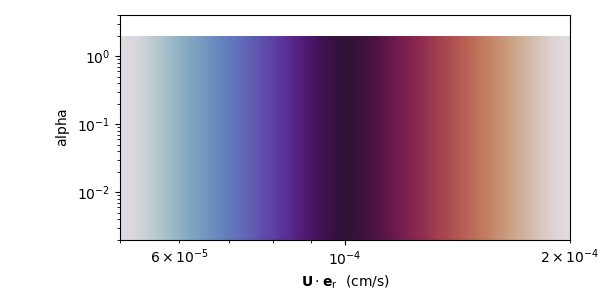

# Parallelism and 3D Rendering

It is absolutely essential that we use parallelism to do 3D rendering. It is very simple in yt and will cut your runtime by significant factors, meaning you wait less time to mess with your transfer function 30 times. YT uses MPI to run in parallel and here's the general process:

- Generally, you want to make a seperate Python script rather than using Jupyter Notebook because it's not possible to run in parallel in an interactive session. 
- To use MPI with python, mpi4py must be downloaded in the environment, with that, you must activate your envirnoment before you run the script.
- At the top of your script, usually after the import statements, you want to put `yt.enable_parallelism()`. You can then make your script as usual. yt knows to run multiple processes if you tell it to with the enable parallelism. 
- After the script is made, you have to run your script on the terminal with the following command:

```
mpirun -np 8 python script.py
```

- Where `mpirun` calls MPI to run a script in parallel, `-np` option indicated the amount of processes to run, `python` says that the script is in python, and `<script.py>` is your python script file. 8 was an arbitrary number, but you can typically use all the cores on your node (given that you won't run into memory problems).

## Running a time series dataset in parallel

There are specific things that you need to include in your scripts if you're using multiple 

# Camera Rotation Movies with 3D Renders

A regular 3D render is useful to just get going but what we really want to do is make movies with our source to really analyze the whole thing. A good way to do with is have the camera object rotate around our source. This section will go over how to do that assuming that you already know how to make a regular 3D render because this method is simply multiple 3D render stitched together. 

### How to make the camera rotate

Rotating the camera uses a simple method in yt itself embed inside of a for loop. The following will rotate your camera automatically with `for i in sc.camera.iter_rotate(2*np.pi, 36, rot_center=ds.domain_center)` where the first argument is the total angle you want the camera to rotate around, the second is the amount of steps it will take to get there, and the last is the point in the data that the camera will rotate around. Here, our camera will rotate 360 degrees around the center of source in 36 steps. 36 will be the total amount of pictures that will be output by this for loop so if you want a smoother video you may want to up this but it will take longer to complete. This is located at the end of my script after I've initialized everything about my scene. A full example will be shown as well.

In [ ]:
for i in sc.camera.iter_rotate(2*np.pi, 36, rot_center=ds.domain_center):
    sc.render()

    if yt.is_root():
        sc.save('your_path/3d_render.png', 
                render=False, 
                sigma_clip=2)

In [ ]:
import yt
import os
import unyt
from yt.units import dimensions
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
from yt.visualization.volume_rendering.api import Scene, create_volume_source, Camera, ColorTransferFunction
import numpy as np

yt.enable_parallelism()

# Loading in data
ds = yt.load('/gpfs/projects/CalderGroup/BrendanSpace/SIM_DATA/hires_urca_problem/plt0030084')

# Setting our field we're looking at
field = ('boxlib', 'Ye_sub')
sc = Scene()

# Setting the radius of the sphere that's rendered
radius = (1.8e3, 'km')

# Setting up the data to render as the Source part of the Scene (sc)
core = ds.sphere(ds.domain_center, (500, 'km'))
my_source = create_volume_source(core, field)
my_source.set_log(False)

# Transfer Function (Coloring)
bounds = (2.8e-5, 3.5e-5) # These are the bounds for our transfer function
tfh = TransferFunctionHelper(ds) # Transfer Functino object to help with syntax
tfh.set_field(field) # Set what field we are looking at
tfh.set_log(False) 
tfh.grey_opacity = True
tfh.set_bounds(bounds) 
tfh.build_transfer_function()
tfh.tf.map_to_colormap(bounds[0], bounds[1], colormap="twilight") # Mapping our Transfer Funciton to color map
my_source.transfer_function = tfh.tf # Add transfer function to our source
sc.add_source(my_source) # Add source to scene

# Camera
sc.add_camera(ds, lens_type="perspective") # Add Camera to scene

# Camera properties
sc.camera.focus = ds.domain_center # Pointing Camera to center
sc.camera.resolution = 1000 # Resolution
sc.camera.north_vector = unyt.unyt_array([0., 1., 0.], 'km') # Setting the "up" vectore for the camera

# Camera Position and field of view
sc.camera.position = ds.domain_center + unyt.unyt_array([0., 0., 0.80*radius[0]], 'km') # moving 3x away along z-direction
sc.camera.set_width(radius)

sc.annotate_axes(alpha=0.001)

# Rotate around the object and render an image
for i in sc.camera.iter_rotate(2*np.pi, 36, rot_center=ds.domain_center):
    sc.render()

    if yt.is_root():
        sc.save(f'/gpfs/projects/CalderGroup/KianSpace/plots/urca/3d_renders/rotate/ye_sub/images/3d_render_{field[1]}_rot{i}.png', render=False, sigma_clip=2)

# 3D Render of Multiple Fields

It may be useful to look at multiple fields in the same render. To do this, the logic we'll follow is adding more data sources to our scene that are looking at different fields we are interested in. This method can easily get out of hand by making seperate Transfer Functions for each source but for this example we will use the same Transfer Function for both sources. We'll follow the same process as before up until we get to creating our sources.

In [ ]:
import yt
from yt.visualization.volume_rendering.api import Scene, create_volume_source
import unyt
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
import numpy as np

yt.enable_parallelism()

ds = yt.load('/gpfs/projects/CalderGroup/BrendanSpace/SIM_DATA/hires_urca_problem/plt0030084')
ds.force_periodicity()
field1 = ('boxlib', 'rhoX(na23)')
field2 = ('boxlib', 'rhoX(ne23)')

sc = Scene()

radius = (1.8e3, 'km')

Notice that we've set the two fields we want to look at. We now want to create our sources with that.

In [ ]:
core = ds.sphere(ds.domain_center, radius)
volume1 = create_volume_source(core, field1)
volume2 = create_volume_source(core, field2)
volume1.set_log(False)
volume2.set_log(False)

We can now apply our transfer function to these sources and then render.

In [ ]:
# Transfer Function
bounds = (7e5, 5e-4)
tfh = TransferFunctionHelper(ds)
tfh.set_log(False)
tfh.grey_opacity = True
tfh.set_bounds(bounds)
tfh.build_transfer_function()

tfh.tf.map_to_colormap(mi=bounds[0], ma=bounds[1], scale=2, colormap="twilight")

volume1.transfer_function = tfh.tf
volume2.transfer_function = tfh.tf

# Adding sources to Scene
sc.add_source(volume1)
sc.add_source(volume2)

# Camera
sc.add_camera(ds, lens_type="perspective")
sc.camera.focus = ds.domain_center
sc.camera.resolution = 500
sc.camera.north_vector = unyt.unyt_array([0., 1., 0.], 'km')
sc.camera.position = ds.domain_center + unyt.unyt_array([0., 0., 0.80*radius[0]], 'km')
sc.camera.set_width(radius)

# Render
sc.render()
if yt.is_root():
    sc.save(f"/gpfs/projects/CalderGroup/KianSpace/reu2023/plots/urca/3d_renders/frames/{field1[1]}_{field2[1]}_3d_render", render=False, sigma_clip=2)